In [4]:
!pip install qulacs mpi4py numpy matplotlib

In [11]:
from qulacs import QuantumState, QuantumCircuit, Observable
from qulacs.gate import RX, RY, RZ, CNOT, DenseMatrix
import numpy as np
import time
from mpi4py import MPI
import matplotlib.pyplot as plt

def qc_autoenc(num_qubits):
    num_layers = 2
    qc = QuantumCircuit(num_qubits)

    # Capa inicial de rotaciones
    for i in range(num_qubits):
        angle_x = 2*np.pi/(1*(i+1))
        angle_y = 2*np.pi/(2*(i+1))
        qc.add_gate(RX(i, angle_x))
        qc.add_gate(RY(i, angle_y))

    # Capas entrelazadas
    for l in range(num_layers):
        # Entrelazamiento
        for i in range(num_qubits):
            for j in range(i+1, num_qubits):
                qc.add_gate(CNOT(i, j))
        
        # Rotaciones parametrizadas
        for i in range(num_qubits):
            angle_x = 2*np.pi*(l+1)/(3*(i+1))
            angle_y = 2*np.pi*(l+1)/(4*(i+1))
            angle_z = 2*np.pi*(l+1)/(5*(i+1))
            qc.add_gate(RX(i, angle_x))
            qc.add_gate(RY(i, angle_y))
            qc.add_gate(RZ(i, angle_z))

    # Capa final de rotaciones inversas
    for i in range(num_qubits):
        angle_y = -2*np.pi/(2*(i+1))
        angle_x = -2*np.pi/(1*(i+1))
        qc.add_gate(RY(i, angle_y))
        qc.add_gate(RX(i, angle_x))

    return qc

def run_simulation(num_qubits, comm): #vector de estados
    # Crear el circuito
    circuit = qc_autoenc(num_qubits)
    
    # Crear el estado cuántico
    state = QuantumState(num_qubits)
    state.set_zero_state()
    
    # Ejecutar el circuito
    start_time = time.time()
    circuit.update_quantum_state(state)
    end_time = time.time()
    
    # Calcular el tiempo de ejecución
    execution_time = end_time - start_time
    
    # Recopilar tiempos de todos los procesos
    all_times = comm.gather(execution_time, root=0)
    
    if comm.rank == 0:
        # Calcular estadísticas
        mean_time = np.mean(all_times)
        median_time = np.median(all_times)
        std_time = np.var(all_times)
        return mean_time, median_time, std_time
    else:
        return None, None, None

d

Procesando 1 qubits...
Procesando 2 qubits...
Procesando 3 qubits...
Procesando 4 qubits...
Procesando 5 qubits...
Procesando 6 qubits...
Procesando 7 qubits...
Procesando 8 qubits...
Procesando 9 qubits...
Procesando 10 qubits...
Procesando 11 qubits...
Procesando 12 qubits...
Procesando 13 qubits...
Procesando 14 qubits...
Procesando 15 qubits...
Procesando 16 qubits...
Procesando 17 qubits...
Procesando 18 qubits...
Procesando 19 qubits...
Procesando 20 qubits...


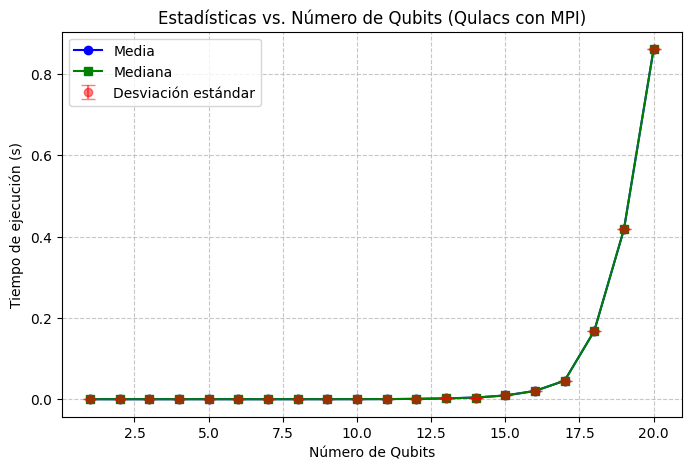

In [12]:
def main():
    # Inicializar MPI
    comm = MPI.COMM_WORLD
    rank = comm.rank
    
    range_qubits = 20
    repetitions = 20
    
    time_statevector_mean = []
    time_statevector_median = []
    time_statevector_std = []
    
    if rank == 0:
        qubits_list = list(range(1, range_qubits+1))
    else:
        qubits_list = None
    
    # Distribuir la lista de qubits a todos los procesos
    qubits_list = comm.bcast(qubits_list, root=0)
    
    for num_qubits in qubits_list:
        if rank == 0:
            print(f"Procesando {num_qubits} qubits...")
        
        # Ejecutar múltiples repeticiones
        all_means = []
        all_medians = []
        all_stds = []
        
        for _ in range(repetitions):
            mean, median, std = run_simulation(num_qubits, comm)
            if rank == 0:
                all_means.append(mean)
                all_medians.append(median)
                all_stds.append(std)
        
        if rank == 0:
            # Promediar los resultados de las repeticiones
            final_mean = np.mean(all_means)
            final_median = np.mean(all_medians)
            final_std = np.mean(all_stds)
            
            time_statevector_mean.append(final_mean)
            time_statevector_median.append(final_median)
            time_statevector_std.append(final_std)
    
    if rank == 0:
        # Imprimir resultados
        print("Medias:", time_statevector_mean)
        print("Medianas:", time_statevector_median)
        print("Desviaciones estándar:", time_statevector_std)
        
        # Graficar resultados
        #plt.figure(figsize=(8, 5))
        #plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
        #plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
        #plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
        #            fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)
        
        #plt.xlabel('Número de Qubits')
        #plt.ylabel('Tiempo de ejecución (s)')
        #plt.title('Estadísticas vs. Número de Qubits (Qulacs con MPI)')
        #plt.legend()
        #plt.grid(True, linestyle='--', alpha=0.7)
        #plt.savefig('quantum_autoencoder_performance.png')
        #plt.show()

if __name__ == "__main__":
    main()

In [18]:
def simulate_with_shots(qc, shots=2048):
    """Simula el circuito y realiza mediciones (equivalentes a shots en Qiskit)"""
    num_qubits = qc.get_qubit_count()
    state = QuantumState(num_qubits)
    state.set_zero_state()
    
    # Ejecutar el circuito
    qc.update_quantum_state(state)
    
    # Realizar mediciones
    counts = {}
    for _ in range(shots):
        # Obtener el vector de estado completo
        state_vector = state.get_vector()
        
        # Calcular probabilidades para cada estado base
        probabilities = np.abs(state_vector)**2
        
        # Muestrear un resultado basado en las probabilidades
        outcome_idx = np.random.choice(len(state_vector), p=probabilities)
        outcome_str = format(outcome_idx, f'0{num_qubits}b')[::-1]  # Binario, qubit 0 es el LSB
        
        counts[outcome_str] = counts.get(outcome_str, 0) + 1
    
    return counts

def run_simulation_2(num_qubits, shots=2048, comm=None):
    qc = qc_autoenc(num_qubits)
    
    start_time = time.time()
    counts = simulate_with_shots(qc, shots)
    end_time = time.time()
    
    execution_time = end_time - start_time
    
    if comm is not None:
        all_times = comm.gather(execution_time, root=0)
        
        if comm.rank == 0:
            mean_time = np.mean(all_times)
            median_time = np.median(all_times)
            std_time = np.std(all_times)
            return mean_time, median_time, std_time
        else:
            return None, None, None
    else:
        return execution_time, execution_time, 0.0

Procesando 1 qubits...
Procesando 2 qubits...
Procesando 3 qubits...
Procesando 4 qubits...
Procesando 5 qubits...
Procesando 6 qubits...
Procesando 7 qubits...
Procesando 8 qubits...
Procesando 9 qubits...
Procesando 10 qubits...
Procesando 11 qubits...
Procesando 12 qubits...
Procesando 13 qubits...
Procesando 14 qubits...
Procesando 15 qubits...
Procesando 16 qubits...
Procesando 17 qubits...
Procesando 18 qubits...
Procesando 19 qubits...
Procesando 20 qubits...
Medias: [np.float64(0.060452377796173094), np.float64(0.05497277975082397), np.float64(0.05573596954345703), np.float64(0.06371748447418213), np.float64(0.05495473146438599), np.float64(0.05641406774520874), np.float64(0.056030774116516115), np.float64(0.06144480705261231), np.float64(0.06288251876831055), np.float64(0.07547705173492432), np.float64(0.09234615564346313), np.float64(0.13327111005783082), np.float64(0.20106513500213624), np.float64(0.3394665837287903), np.float64(0.6759593844413757), np.float64(2.018630349636

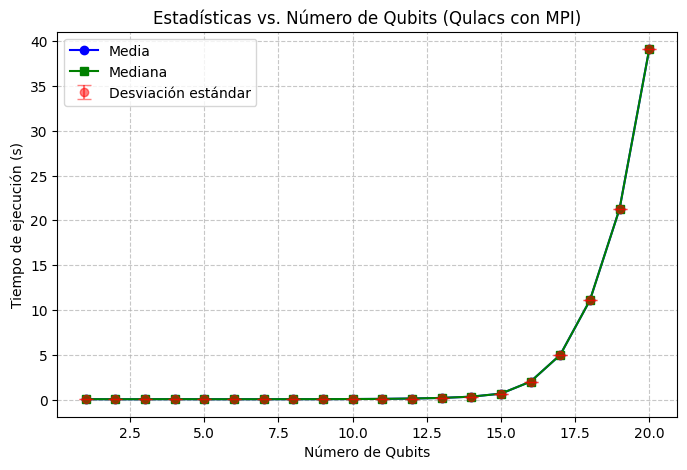

In [19]:
def main_2():
    comm = MPI.COMM_WORLD
    rank = comm.rank
    
    range_qubits = 20
    repetitions = 20
    shots = 2048
    
    time_run_mean = []
    time_run_median = []
    time_run_std = []
    
    if rank == 0:
        qubits_list = list(range(1, range_qubits+1))
    else:
        qubits_list = None
    
    qubits_list = comm.bcast(qubits_list, root=0)
    
    for num_qubits in qubits_list:
        if rank == 0:
            print(f"Procesando {num_qubits} qubits...")
        
        all_means = []
        all_medians = []
        all_stds = []
        
        for _ in range(repetitions):
            mean, median, std = run_simulation_2(num_qubits, shots, comm)
            if rank == 0:
                all_means.append(mean)
                all_medians.append(median)
                all_stds.append(std)
        
        if rank == 0:
            final_mean = np.mean(all_means)
            final_median = np.mean(all_medians)
            final_std = np.mean(all_stds)
            
            time_run_mean.append(final_mean)
            time_run_median.append(final_median)
            time_run_std.append(final_std)
    
    if rank == 0:
        print("Medias:", time_run_mean)
        print("Medianas:", time_run_median)
        print("Desviaciones estándar:", time_run_std)
        
        qubits = list(range(1, range_qubits+1))
        
        #plt.figure(figsize=(8, 5))
        #plt.plot(qubits, time_run_mean, 'o-', label='Media', color='blue')
        #plt.plot(qubits, time_run_median, 's-', label='Mediana', color='green')
        #plt.errorbar(qubits, time_run_mean, yerr=time_run_std, 
        #            fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)
        
        #plt.xlabel('Número de Qubits')
        #plt.ylabel('Tiempo de ejecución (s)')
        #plt.title('Estadísticas vs. Número de Qubits (Qulacs con MPI)')
        #plt.legend()
        #plt.grid(True, linestyle='--', alpha=0.7)
        #plt.savefig('quantum_autoencoder_performance_shots.png')
        #plt.show()

if __name__ == "__main__":
    main_2()